In [1]:
import numpy as np
from random import shuffle
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 20)

その分野の良いものを見つけたければ、その分野の専門家・マニア・オタクに聞くべきだ、素人がどんなに多くの票を入れたからと言って、それが良いものだとは思わない

という思想の下、玄人優先のランキングアルゴリズムを作る。誰の票を重く見るかを示す変数の決め方を変えれば、カスタマイズ可能になることが望ましい。

与えられる情報は、
①ノミネート数
②タイトルのID
③だれがどのタイトルに何票投票したか
④投票者各位がどのタイトルの中から投票タイトルを選択したか

となる。

In [2]:
#db = pd.read_csv("data.csv")

In [3]:
#   ミニテスト用
N = 10 #   ノミネートタイトル数
M = 10**2   #   投票者数
L = 5  #   投票者一人当たりのタイトル経験数スケール(目安)
K = 3  #   一人当たりの投票権利数
LOGSCALE_RANGE = 10

In [4]:
N = 100 #   ノミネートタイトル数
M = 10**4   #   投票者数
L = 10  #   投票者一人当たりのタイトル経験数スケール(目安)
K = 10  #   一人当たりの投票権利数
LOGSCALE_RANGE = 10

In [5]:
def make_nominated_title_db(N, value_vector=None, popularity_vector=None):
    col = ["id", "popularity", "experienced counter", "value", "simple vote", "simple vote ranking", "simple vote rate", "simple vote rate ranking", "corrected vote", "corrected vote ranking", "professional vote point", "professional ranking"]
    info = [[None for _ in range(len(col))] for _ in range(N)]
    nominated_title_db = pd.DataFrame(info, columns=col)
    nominated_title_db["id"] = nominated_title_db.index
    nominated_title_db["popularity"] = popularity_vector
    nominated_title_db["value"] = value_vector
    nominated_title_db["experienced counter"] = 0
    nominated_title_db["simple vote"] = 0
    nominated_title_db["corrected vote"] = 0
    nominated_title_db["professional vote point"] = 0
    nominated_title_db["corrected vote"] = 0

    return nominated_title_db

In [6]:
#   データ生成のセル
popularity_vector = np.exp(-LOGSCALE_RANGE*np.arange(N)/N)
value_vector = np.random.randn(N) + (N - np.arange(N))/N
value_vector += -np.min(value_vector)
value_vector /= np.max(value_vector)
nominated_title_db = make_nominated_title_db(N, value_vector=value_vector, popularity_vector=popularity_vector)

def make_data(N, M, L, K, nominated_title_db):
    col = ["name", "experienced title list", "number of experienced title", "voted title info list", "poll", "waight"]
    info = [[None for _ in range(len(col))] for _ in range(M)]
    voter_db = pd.DataFrame(info, columns=col)
    voter_db["name"] = voter_db.index

    j1 = col.index("experienced title list")
    j2 = col.index("number of experienced title")
    waight_col_j = col.index("waight")
    voted_title_col_j = col.index("voted title info list")
    poll_col_j = col.index("poll")

    popularity_arr, value_arr = None, None
    if nominated_title_db.at[0, "popularity"] is not None:
        popularity_arr = np.array(list(nominated_title_db.loc[:,"popularity"].values))
    if nominated_title_db.at[0, "value"] is not None:
        value_arr = np.array(list(nominated_title_db.loc[:,"value"].values))

    for i in range(len(voter_db)):
        number_of_experienced_title = N
        for _ in range(int(np.log2(N/L))):
            number_of_experienced_title = np.random.randint(1,number_of_experienced_title+1)
        t = list(set(np.random.choice([i for i in range(N)], number_of_experienced_title, p=popularity_arr/np.sum(popularity_arr))))
        shuffle(t)
        voter_db.iat[i, j1] = t
        voter_db.iat[i, j2] = len(t)
        voter_db.iat[i, waight_col_j] = len(t) #   ここはどうする？

        u = t[:np.random.randint(1, len(t)+1)]
        lst = []
        kh = np.random.randint(1, K+1, len(u))
        M = 0
        for h in range(len(u)):
            kh[h] += int(K*value_arr[u[h]])
            M += kh[h]
        while np.sum(kh) > K:
            h = np.random.randint(0,len(kh))
            if kh[h] > 0:
                kh[h] -= 1
                M -= 1
        for h, voted_point in enumerate(kh):
            if voted_point > 0:
                lst.append((u[h], voted_point))
        voter_db.iat[i, voted_title_col_j] = lst
        voter_db.iat[i, poll_col_j] = M
    
    voter_db.iloc[:,waight_col_j] *= K/voter_db.iloc[:,poll_col_j]  #   票数が少なかったら重み補正　ここはないほうが良い場合もあるかな
    voter_db.iloc[:,waight_col_j] /= sum(voter_db.iloc[:,waight_col_j])
    return voter_db
voter_db = make_data(N, M, L, K, nominated_title_db)
voter_db

,name,experienced title list,number of experienced title,voted title info list,poll,waight
0,0,"[0, 15, 2, 5, 1, 30, 9, 10, 3, 12, 11, 7, 23, ...",19,"[(2, 8), (23, 2)]",10,0.000226
1,1,"[8, 5, 0, 9, 14, 11, 4, 1, 27, 2, 24, 7, 3, 19]",14,"[(0, 6), (9, 3), (11, 1)]",10,0.000166
2,2,"[2, 1, 15, 4]",4,"[(2, 10)]",10,0.000048
3,3,"[5, 63, 9, 0, 2, 19]",6,"[(9, 3), (2, 6), (19, 1)]",10,0.000071
4,4,"[3, 0]",2,"[(3, 4), (0, 6)]",10,0.000024
...,...,...,...,...,...,...
9995,9995,"[2, 6, 5, 0, 50, 13, 3, 32, 31, 15, 8, 9]",12,"[(2, 4), (5, 4), (13, 1), (32, 1)]",10,0.000143
9996,9996,"[2, 3, 0, 8, 10, 11, 1]",7,"[(2, 2), (3, 5), (0, 3)]",10,0.000083
9997,9997,"[2, 18, 3, 11]",4,"[(18, 5), (3, 5)]",10,0.000048
9998,9998,"[3, 1, 7, 12, 17, 14, 27, 21, 6, 19, 9, 0, 2, ...",16,"[(21, 1), (19, 2), (0, 3), (2, 1), (5, 3)]",10,0.00019


In [7]:
def count_experiment(voter_db, nominated_title_db):
    j = list(voter_db.columns).index("experienced title list")
    k = list(nominated_title_db.columns).index("experienced counter")
    for i in range(len(voter_db)):
        for title_id in voter_db.iat[i, j]:
            nominated_title_db.iat[title_id, k] += 1
    nominated_title_db.sort_values("experienced counter", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    return nominated_title_db
nominated_title_db = count_experiment(voter_db, nominated_title_db)
nominated_title_db

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking
0,0,1.000000,5373,0.651119,0,None,None,None,0,None,0,None
1,1,0.904837,5108,0.565859,0,None,None,None,0,None,0,None
2,2,0.818731,4824,0.745161,0,None,None,None,0,None,0,None
3,3,0.740818,4681,0.703788,0,None,None,None,0,None,0,None
4,4,0.670320,4405,0.619621,0,None,None,None,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
95,88,0.000151,1,0.673236,0,None,None,None,0,None,0,None
96,94,0.000083,0,0.200342,0,None,None,None,0,None,0,None
97,95,0.000075,0,0.773912,0,None,None,None,0,None,0,None
98,98,0.000055,0,0.435096,0,None,None,None,0,None,0,None


In [8]:
def make_pointVector(N):
    point_vector = np.zeros(N)

    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    waight_col_j = list(voter_db.columns).index("waight")

    for i in range(len(voter_db)):
        for title_id, voted_point in voter_db.iat[i,voted_title_col_j]:
            point_vector[title_id] += voted_point * voter_db.iat[i,waight_col_j]
    
    return point_vector
point_vector = make_pointVector(N)

In [9]:
def input_simple_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M):
    simple_vote_col_j = list(nominated_title_db.columns).index("simple vote")
    simple_vote_ranking_col_j = list(nominated_title_db.columns).index("simple vote ranking")
    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    nominated_title_db.sort_values("id", inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    for i in range(M):
        for title_id, vote_number in voter_db.iat[i, voted_title_col_j]:
            nominated_title_db.iat[title_id, simple_vote_col_j] += vote_number

    nominated_title_db.sort_values("simple vote", ascending=False, inplace=True)
    nominated_title_db["simple vote ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, simple_vote_col_j] == nominated_title_db.iat[i+1, simple_vote_col_j]:
            nominated_title_db.iat[i+1, simple_vote_ranking_col_j] = nominated_title_db.iat[i, simple_vote_ranking_col_j]
    return nominated_title_db
nominated_title_db = input_simple_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M)
nominated_title_db.reset_index(drop=True, inplace=True)
nominated_title_db

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking
0,0,1.000000,5373,0.651119,8462,1,None,None,0,None,0,None
1,2,0.818731,4824,0.745161,8025,2,None,None,0,None,0,None
2,3,0.740818,4681,0.703788,7709,3,None,None,0,None,0,None
3,5,0.606531,4088,0.882900,7330,4,None,None,0,None,0,None
4,1,0.904837,5108,0.565859,6524,5,None,None,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
95,88,0.000151,1,0.673236,0,86,None,None,0,None,0,None
96,86,0.000184,2,0.433716,0,86,None,None,0,None,0,None
97,73,0.000676,9,0.410031,0,86,None,None,0,None,0,None
98,63,0.001836,24,0.125082,0,86,None,None,0,None,0,None


In [10]:
def make_simple_vote_rate_ranking(nominated_title_db, N):
    rate_j = list(nominated_title_db.columns).index("simple vote rate")
    ranking_j = list(nominated_title_db.columns).index("simple vote rate ranking")
    
    nominated_title_db["simple vote rate"] = nominated_title_db["simple vote"] / nominated_title_db["experienced counter"]
    nominated_title_db.fillna(0, inplace=True)
    nominated_title_db.sort_values("simple vote rate", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)

    nominated_title_db["simple vote rate ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, rate_j] == nominated_title_db.iat[i+1, rate_j]:
            nominated_title_db.iat[i+1, ranking_j] = nominated_title_db.iat[i, ranking_j]
    return nominated_title_db
make_simple_vote_rate_ranking(nominated_title_db, N)

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking
0,96,0.000068,2,0.403221,5,74,2.500000,1,0,0,0,0
1,80,0.000335,3,0.453057,7,72,2.333333,2,0,0,0,0
2,85,0.000203,2,0.767669,4,77,2.000000,3,0,0,0,0
3,78,0.000410,2,0.346241,4,77,2.000000,3,0,0,0,0
4,83,0.000249,6,0.488829,12,68,2.000000,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,98,0.000055,0,0.435096,0,86,0.000000,86,0,0,0,0
96,92,0.000101,1,0.487321,0,86,0.000000,86,0,0,0,0
97,97,0.000061,1,0.650680,0,86,0.000000,86,0,0,0,0
98,95,0.000075,0,0.773912,0,86,0.000000,86,0,0,0,0


In [11]:
def input_corrected_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M):
    corrected_vote_col_j = list(nominated_title_db.columns).index("corrected vote")
    corrected_vote_ranking_col_j = list(nominated_title_db.columns).index("corrected vote ranking")
    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    waight_col_j = list(voter_db.columns).index("waight")
    nominated_title_db.sort_values("id", inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    for i in range(M):
        for title_id, vote_number in voter_db.iat[i, voted_title_col_j]:
            nominated_title_db.iat[title_id, corrected_vote_col_j] += vote_number*voter_db.iat[i, waight_col_j]

    nominated_title_db.sort_values("corrected vote", ascending=False, inplace=True)
    nominated_title_db["corrected vote ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, corrected_vote_col_j] == nominated_title_db.iat[i+1, corrected_vote_col_j]:
            nominated_title_db.iat[i+1, corrected_vote_ranking_col_j] = nominated_title_db.iat[i, corrected_vote_ranking_col_j]
    return nominated_title_db
nominated_title_db = input_corrected_vote_to_nominated_title_db(nominated_title_db, voter_db, N, M)
nominated_title_db.reset_index(drop=True, inplace=True)
nominated_title_db

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking
0,5,0.606531,4088,0.882900,7330,4,1.793053,9,0.756024,1,0,0
1,2,0.818731,4824,0.745161,8025,2,1.663557,13,0.741355,2,0,0
2,3,0.740818,4681,0.703788,7709,3,1.646870,14,0.719583,3,0,0
3,0,1.000000,5373,0.651119,8462,1,1.574912,16,0.698465,4,0,0
4,4,0.670320,4405,0.619621,6062,6,1.376163,26,0.551491,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,88,0.000151,1,0.673236,0,86,0.000000,86,0.000000,86,0,0
96,86,0.000184,2,0.433716,0,86,0.000000,86,0.000000,86,0,0
97,73,0.000676,9,0.410031,0,86,0.000000,86,0.000000,86,0,0
98,77,0.000453,4,0.483879,0,86,0.000000,86,0.000000,86,0,0


In [12]:
def make_pointvector(N):
    point_vector = np.zeros(N)

    experienced_counter = np.zeros(N)
    voted_counter = np.zeros(N)

    voted_title_col_j = list(voter_db.columns).index("voted title info list")
    experienced_title_col_j = list(voter_db.columns).index("experienced title list")
    waight_col_j = list(voter_db.columns).index("waight")

    for i in range(len(voter_db)):
        max_point = 0
        voted_title_id_set = set()
        for pivot_title_id, pivot_voted_point in voter_db.iat[i,voted_title_col_j]:
            voted_title_id_set.add(pivot_title_id)
            voted_counter[pivot_title_id] += pivot_voted_point
            if max_point < pivot_voted_point * voter_db.iat[i,waight_col_j]:
                max_point = pivot_voted_point * voter_db.iat[i,waight_col_j]
            for title_id, voted_point in voter_db.iat[i,voted_title_col_j]:
                point_vector[pivot_title_id] -= voted_point * voter_db.iat[i,waight_col_j]    #   投票された体験同氏の、最大値から見た相対評価
        for experienced_title_id in voter_db.iat[i,experienced_title_col_j]:
            if experienced_title_id in voted_title_id_set:
                point_vector[experienced_title_id] += max_point*(len(voter_db.iat[i,voted_title_col_j]) - 1)    #   投票されたこと自体を評価してベースラインを引き上げ0以上に
            experienced_counter[experienced_title_id] += len(voter_db.iat[i,experienced_title_col_j]) - 1
    
    point_vector -= np.min(point_vector)   #   投票の偏りは指数分布なので、point_vectorも指数分布に近いはず
    point_vector *= len(point_vector) / np.sum(point_vector)
    point_vector = np.log(point_vector + 1)
    satisfaction = voted_counter/(experienced_counter+1)    #   sum(satisfaction) ∝ MK/N    投票の偏りは指数分布なので、satisfactionも指数分布に近いはず
    satisfaction -= np.min(satisfaction)
    satisfaction *= len(satisfaction) / np.sum(satisfaction)
    point_vector += np.log(satisfaction + 2)  #   経験数当たりの被投票数の単調増加関数をかけ、"満足度"を評価に加える
    point_vector *= len(point_vector) / np.sum(np.abs(point_vector))
    
    return point_vector
point_vector = make_pointvector(N)

In [13]:
def input_professional_to_nominated_title_db(nominated_title_db, point_vector, N):
    point_j = list(nominated_title_db.columns).index("professional vote point")
    ranking_j = list(nominated_title_db.columns).index("professional ranking")

    nominated_title_db.sort_values("id", ascending=True, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    nominated_title_db["professional vote point"] = point_vector
    nominated_title_db.sort_values("professional vote point", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    nominated_title_db.iloc[:, ranking_j] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, point_j] == nominated_title_db.iat[i+1, point_j]:
            nominated_title_db.iat[i+1, ranking_j] = nominated_title_db.iat[i, ranking_j]
    return nominated_title_db
nominated_title_db = input_professional_to_nominated_title_db(nominated_title_db, point_vector, N)
nominated_title_db.reset_index(drop=True, inplace=True)
nominated_title_db

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking
0,4,0.670320,4405,0.619621,6062,6,1.376163,26,0.551491,5,1.734714,1
1,3,0.740818,4681,0.703788,7709,3,1.646870,14,0.719583,3,1.719728,2
2,10,0.367879,3031,0.750653,4465,7,1.473111,20,0.487589,7,1.586742,3
3,5,0.606531,4088,0.882900,7330,4,1.793053,9,0.756024,1,1.579343,4
4,9,0.406570,3335,0.590994,3560,9,1.067466,38,0.340924,10,1.548320,5
...,...,...,...,...,...,...,...,...,...,...,...,...
95,73,0.000676,9,0.410031,0,86,0.000000,86,0.000000,86,0.660269,85
96,86,0.000184,2,0.433716,0,86,0.000000,86,0.000000,86,0.660269,85
97,77,0.000453,4,0.483879,0,86,0.000000,86,0.000000,86,0.660269,85
98,99,0.000050,0,0.411989,0,86,0.000000,86,0.000000,86,0.660269,85


In [14]:
pd.set_option('display.max_rows', None)

def add_value_ranking(nominated_title_db, N):
    nominated_title_db["value ranking"] = 0
    nominated_title_db.sort_values("value", ascending=False, inplace=True)
    nominated_title_db.reset_index(drop=True, inplace=True)
    nominated_title_db.loc[:, "value ranking"] = np.arange(N) + 1
    for i in range(N-1):
        if nominated_title_db.iat[i, -1] == nominated_title_db.iat[i+1, -1]:
            nominated_title_db.iat[i+1, -1] = nominated_title_db.iat[i, -1]
    return nominated_title_db
add_value_ranking(nominated_title_db, N)
nominated_title_db.sort_values("professional ranking")

,id,popularity,experienced counter,value,simple vote,simple vote ranking,simple vote rate,simple vote rate ranking,corrected vote,corrected vote ranking,professional vote point,professional ranking,value ranking
40,4,0.670320,4405,0.619621,6062,6,1.376163,26,0.551491,5,1.734714,1,41
27,3,0.740818,4681,0.703788,7709,3,1.646870,14,0.719583,3,1.719728,2,28
15,10,0.367879,3031,0.750653,4465,7,1.473111,20,0.487589,7,1.586742,3,16
4,5,0.606531,4088,0.882900,7330,4,1.793053,9,0.756024,1,1.579343,4,5
44,9,0.406570,3335,0.590994,3560,9,1.067466,38,0.340924,10,1.548320,5,45
5,18,0.165299,1695,0.847237,2397,13,1.414159,25,0.308189,11,1.517237,6,6
49,1,0.904837,5108,0.565859,6524,5,1.277212,29,0.544566,6,1.482158,7,50
50,7,0.496585,3698,0.562088,3970,8,1.073553,37,0.390264,8,1.426289,8,51
18,2,0.818731,4824,0.745161,8025,2,1.663557,13,0.741355,2,1.409343,9,19
1,23,0.100259,1105,0.981950,1935,17,1.751131,11,0.268078,13,1.395415,10,2


In [15]:
pd.set_option('display.max_rows', None)

ranking_db = nominated_title_db[["id", "popularity", "value", "value ranking", "simple vote ranking", "corrected vote ranking", "simple vote rate ranking", "professional ranking"]]
value_top10_ranking_db = ranking_db.sort_values("value ranking").iloc[:10,:]
corrected_vote_top10_ranking_db = ranking_db.sort_values("corrected vote ranking").iloc[:10,:]
simple_vote_rate_top10_ranking_db = ranking_db.sort_values("simple vote rate ranking").iloc[:10,:]
professional_top10_ranking_db = ranking_db.sort_values("professional ranking").iloc[:10,:]
ranking_db.sort_values("professional ranking", inplace=True)
ranking_db

C:\Users\honka\AppData\Local\Temp\ipykernel_1988\819660259.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranking_db.sort_values("professional ranking", inplace=True)


,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking
40,4,0.670320,0.619621,41,6,5,26,1
27,3,0.740818,0.703788,28,3,3,14,2
15,10,0.367879,0.750653,16,7,7,20,3
4,5,0.606531,0.882900,5,4,1,9,4
44,9,0.406570,0.590994,45,9,10,38,5
5,18,0.165299,0.847237,6,13,11,25,6
49,1,0.904837,0.565859,50,5,6,29,7
50,7,0.496585,0.562088,51,8,8,37,8
18,2,0.818731,0.745161,19,2,2,13,9
1,23,0.100259,0.981950,2,17,13,11,10


In [16]:
value_top10_ranking_db

,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking
0,66,0.001360,1.000000,1,61,56,27,61
1,23,0.100259,0.981950,2,17,13,11,10
2,28,0.060810,0.905293,3,25,24,15,15
3,47,0.009095,0.893907,4,41,39,7,31
4,5,0.606531,0.882900,5,4,1,9,4
5,18,0.165299,0.847237,6,13,11,25,6
6,34,0.033373,0.841404,7,30,29,33,43
7,55,0.004087,0.810746,8,50,55,21,37
8,24,0.090718,0.800940,9,21,18,22,16
9,60,0.002479,0.798518,10,58,61,6,39


In [17]:
corrected_vote_top10_ranking_db

,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking
4,5,0.606531,0.882900,5,4,1,9,4
18,2,0.818731,0.745161,19,2,2,13,9
27,3,0.740818,0.703788,28,3,3,14,2
33,0,1.000000,0.651119,34,1,4,16,21
40,4,0.670320,0.619621,41,6,5,26,1
49,1,0.904837,0.565859,50,5,6,29,7
15,10,0.367879,0.750653,16,7,7,20,3
50,7,0.496585,0.562088,51,8,8,37,8
16,15,0.223130,0.748086,17,10,9,28,18
44,9,0.406570,0.590994,45,9,10,38,5


In [18]:
simple_vote_rate_top10_ranking_db

,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking
77,96,0.000068,0.403221,78,74,74,1,27
67,80,0.000335,0.453057,68,72,83,2,11
13,85,0.000203,0.767669,14,77,75,3,33
82,78,0.000410,0.346241,83,77,69,3,30
61,83,0.000249,0.488829,62,68,65,3,38
9,60,0.002479,0.798518,10,58,61,6,39
3,47,0.009095,0.893907,4,41,39,7,31
55,79,0.000371,0.519376,56,71,67,8,52
4,5,0.606531,0.882900,5,4,1,9,4
54,56,0.003698,0.528491,55,50,49,10,41


In [19]:
professional_top10_ranking_db

,id,popularity,value,value ranking,simple vote ranking,corrected vote ranking,simple vote rate ranking,professional ranking
40,4,0.670320,0.619621,41,6,5,26,1
27,3,0.740818,0.703788,28,3,3,14,2
15,10,0.367879,0.750653,16,7,7,20,3
4,5,0.606531,0.882900,5,4,1,9,4
44,9,0.406570,0.590994,45,9,10,38,5
5,18,0.165299,0.847237,6,13,11,25,6
49,1,0.904837,0.565859,50,5,6,29,7
50,7,0.496585,0.562088,51,8,8,37,8
18,2,0.818731,0.745161,19,2,2,13,9
1,23,0.100259,0.981950,2,17,13,11,10


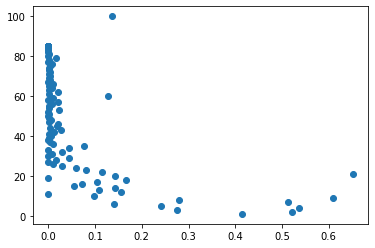

In [20]:
plt.scatter(ranking_db["value"]*ranking_db["popularity"], ranking_db["professional ranking"])

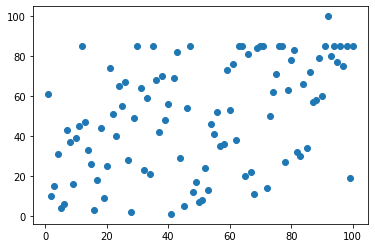

In [21]:
plt.scatter(ranking_db["value ranking"], ranking_db["professional ranking"])

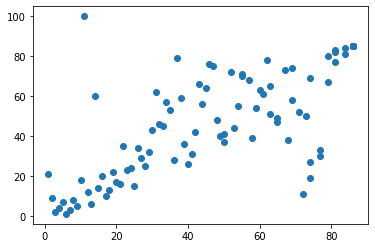

In [22]:
plt.scatter(ranking_db["simple vote ranking"], ranking_db["professional ranking"])

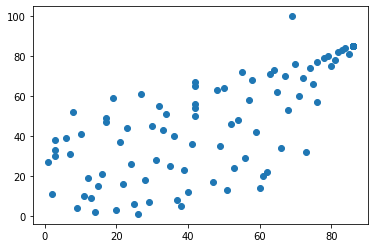

In [23]:
plt.scatter(ranking_db["simple vote rate ranking"], ranking_db["professional ranking"])